The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [3]:
# TODO : import the dataset
df = pd.read_csv('/content/AB_Test_Results.csv')

In [41]:
# TODO : take a quick look at the data
print(df.describe(include='object'))
print(df.describe())
print(df['VARIANT_NAME'].unique())
print(df)

       VARIANT_NAME
count         10000
unique            2
top         variant
freq           5016
            USER_ID       REVENUE
count  10000.000000  10000.000000
mean    4981.080200      0.099447
std     2890.590115      2.318529
min        2.000000      0.000000
25%     2468.750000      0.000000
50%     4962.000000      0.000000
75%     7511.500000      0.000000
max    10000.000000    196.010000
['variant' 'control']
      USER_ID VARIANT_NAME  REVENUE
0         737      variant      0.0
1        2423      control      0.0
2        9411      control      0.0
3        7311      control      0.0
4        6174      variant      0.0
...       ...          ...      ...
9995     1981      control      0.0
9996      502      variant      0.0
9997     9214      variant      0.0
9998     7741      control      0.0
9999     9468      control      0.0

[10000 rows x 3 columns]


Let's see if there are users who have two A/B test groups

count    6324.000000
mean        1.243675
std         0.429333
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: VARIANT_NAME, dtype: float64


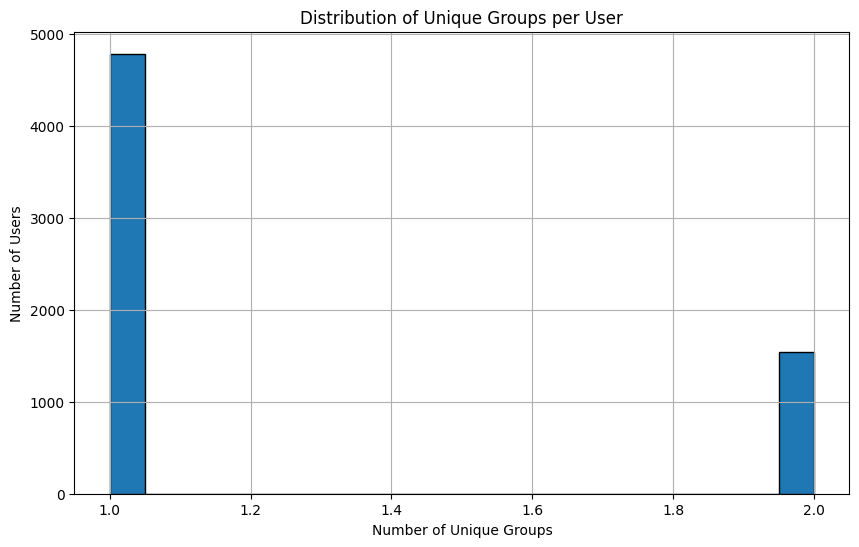

In [10]:
# TODO : Look at the distribution of the number of unique groups for each user
user_group_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
print(user_group_counts.describe())

plt.figure(figsize=(10, 6))
user_group_counts.hist(bins=20, edgecolor='black')
plt.title('Distribution of Unique Groups per User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Number of Users')
plt.show()

VARIANT_NAME
1    0.756325
2    0.243675
Name: proportion, dtype: float64


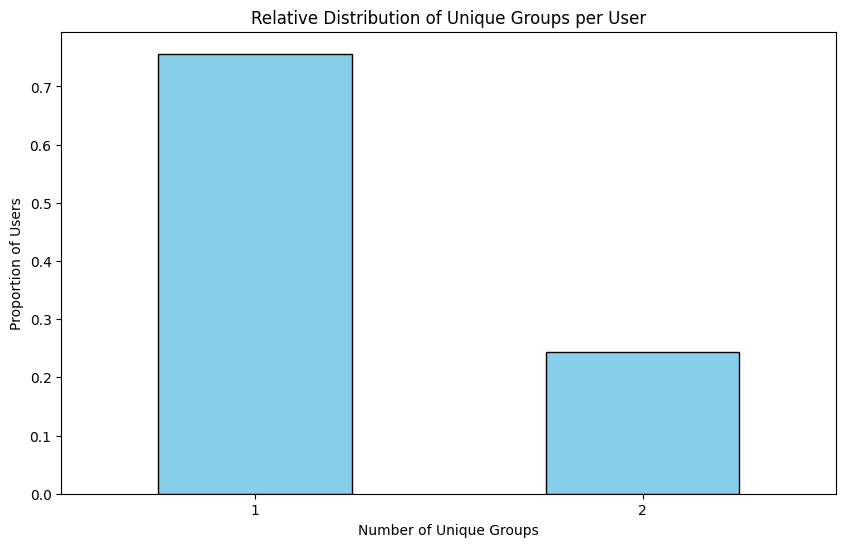

In [13]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
group_distribution = user_group_counts.value_counts(normalize=True).sort_index()
print(group_distribution)

plt.figure(figsize=(10, 6))
group_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Relative Distribution of Unique Groups per User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Proportion of Users')
plt.xticks(rotation=0)
plt.show()

What can you observe ? Should we exclude these users ? Why ?

20% of users have two groups
If the goal is to see difference in revenue between two groups then yes, they should be excluded

In [21]:
# TODO : users have 1 A/B test group ?

# TODO : Take only these users
users_with_one_group = user_group_counts[user_group_counts == 1]
print(f"Number of users with exactly one A/B test group: {len(users_with_one_group)}")

df_one_group = df[df['USER_ID'].isin(users_with_one_group.index)]
print(df_one_group.info())

Number of users with exactly one A/B test group: 4783
<class 'pandas.core.frame.DataFrame'>
Index: 6070 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       6070 non-null   int64  
 1   VARIANT_NAME  6070 non-null   object 
 2   REVENUE       6070 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 189.7+ KB
None


In [51]:
# TODO : Leave only records with users with the 1st ab test group
df_first_group = df_one_group[df_one_group['VARIANT_NAME'] == 'control']
print(df_first_group.info())

# TODO : Check that the number of users matches what it was before the exception
unique_users_filtered = df_first_group['USER_ID'].nunique()
unique_users_before = users_with_one_group.nunique()
if unique_users_filtered == unique_users_before:
    print("Number of users matches expectations.")
else:
    print("Number of users does not match expectations.")
print(f"Number of unique users in filtered dataset: {unique_users_filtered}")
print(df_first_group)

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 7 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       3026 non-null   int64  
 1   VARIANT_NAME  3026 non-null   object 
 2   REVENUE       3026 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 94.6+ KB
None
Number of users does not match expectations.
Number of unique users in filtered dataset: 2390
      USER_ID VARIANT_NAME  REVENUE
7        9168      control      0.0
9        7548      control      0.0
10       8395      control      0.0
11       1184      control      0.0
12       7165      control      0.0
...       ...          ...      ...
9986     2161      control      0.0
9988      428      control      0.0
9994     3129      control      0.0
9998     7741      control      0.0
9999     9468      control      0.0

[3026 rows x 3 columns]


Let's see how the data is distributed

<ipython-input-52-8b5cdcee9d5b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_first_group, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')


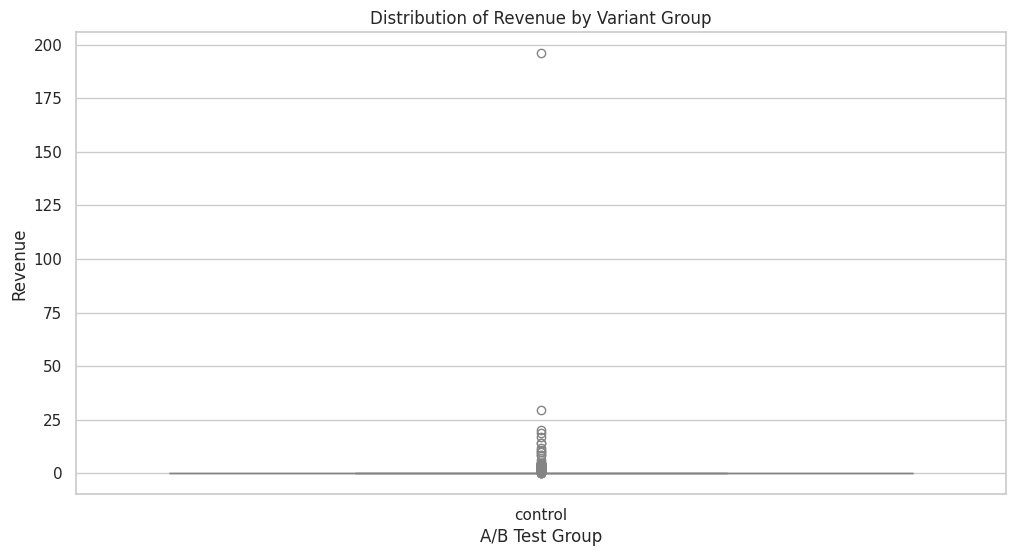

In [52]:
# TODO : Check how the data is distributed using a box plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_first_group, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')

plt.title('Distribution of Revenue by Variant Group')
plt.xlabel('A/B Test Group')
plt.ylabel('Revenue')
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [53]:
# TODO : Sort these revenue values in descending order

df_first_group_sorted = df_first_group.sort_values(by='REVENUE', ascending=False)
print(df_first_group_sorted.head())

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
8168     2166      control    29.32
6412     1053      control    20.07
5530      282      control    18.56
758      4445      control    17.05


In [54]:
# TODO : See if user 3342 had other events with a strong outlier
user_3342_data = df[df['USER_ID'] == 3342]
print(user_3342_data)

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<class 'pandas.core.frame.DataFrame'>
Index: 3025 entries, 7 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       3025 non-null   int64  
 1   VARIANT_NAME  3025 non-null   object 
 2   REVENUE       3025 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 94.5+ KB
None


<ipython-input-55-47623b9f60a7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_first_group_filtered, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')


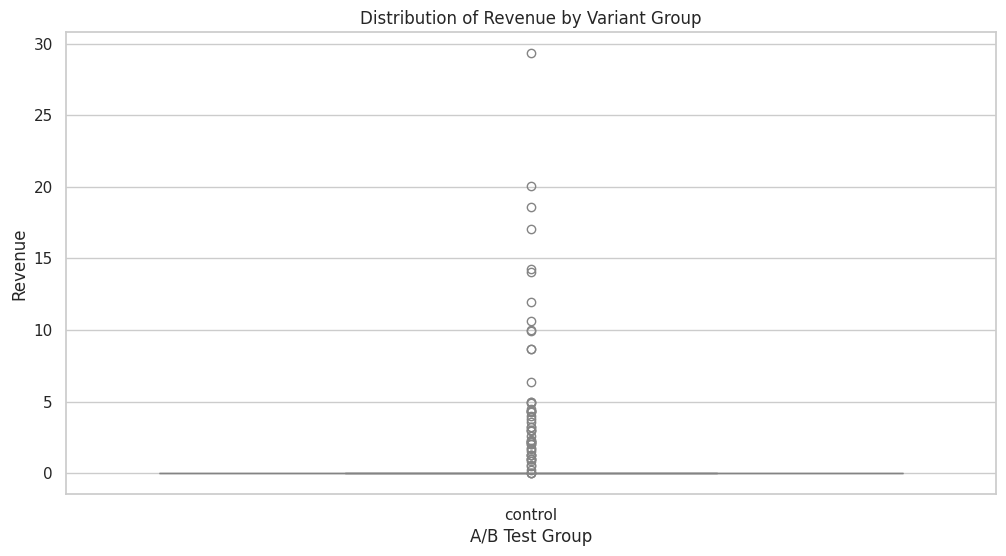

In [55]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
df_first_group_filtered = df_first_group[df_first_group['USER_ID'] != 3342]
print(df_first_group_filtered.info())

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_first_group_filtered, x='VARIANT_NAME', y='REVENUE', palette='coolwarm')

plt.title('Distribution of Revenue by Variant Group')
plt.xlabel('A/B Test Group')
plt.ylabel('Revenue')
plt.show()


What can you say about the users and their purchases ?

That most of them do not purchase anything...

Number of users with both zero and positive revenue: 24


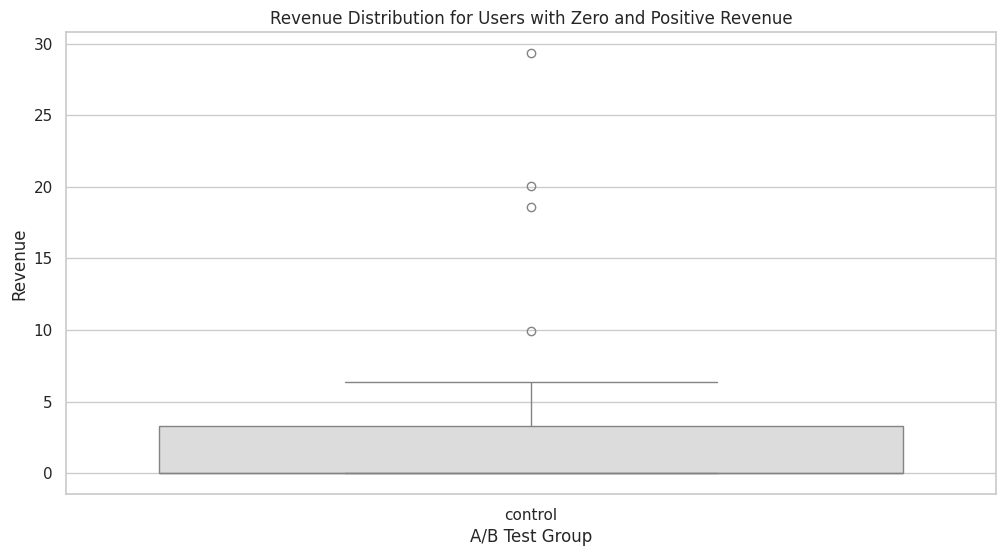

In [60]:
# TODO : Check if there are users who have records with zero and positive revenue

users_with_zero_revenue = df_first_group_filtered[df_first_group_filtered['REVENUE'] == 0]['USER_ID'].unique()
users_with_positive_revenue = df_first_group_filtered[df_first_group_filtered['REVENUE'] > 0]['USER_ID'].unique()
users_with_both_revenue = set(users_with_zero_revenue) & set(users_with_positive_revenue)
print(f"Number of users with both zero and positive revenue: {len(users_with_both_revenue)}")

df_users_with_both_revenue = df_first_group_filtered[df_first_group_filtered['USER_ID'].isin(users_with_both_revenue)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_users_with_both_revenue, x='VARIANT_NAME', y='REVENUE', hue = 'VARIANT_NAME', legend = False, palette='coolwarm')

plt.title('Revenue Distribution for Users with Zero and Positive Revenue')
plt.xlabel('A/B Test Group')
plt.ylabel('Revenue')
plt.show()

Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [62]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
df_user_revenue = df_first_group_filtered.groupby('USER_ID')['REVENUE'].sum().reset_index()

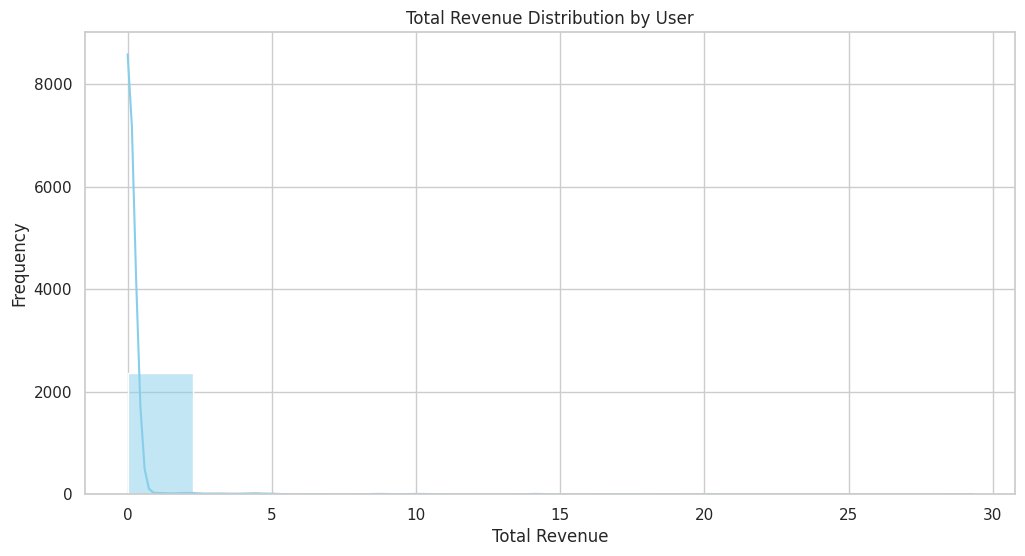

In [70]:
# TODO : Visualize the resulting distribution of the data again.
plt.figure(figsize=(12, 6))
sns.histplot(df_user_revenue['REVENUE'], kde=True, color='skyblue')
plt.title('Total Revenue Distribution by User')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [74]:
# TODO : get metrics by groups
grouped_metrics = df_one_group.groupby('VARIANT_NAME')['REVENUE'].describe()
print(grouped_metrics)
# TODO : create two additional metrics to see relative changes
#mean revenue difference
mean_revenue_variant = df_one_group.groupby('VARIANT_NAME')['REVENUE'].mean()
mean_revenue_diff = mean_revenue_variant.diff().iloc[-1]  # Last entry gives difference between the two groups
#percentage change in total revenue for each group
total_revenue_variant = df_one_group.groupby('VARIANT_NAME')['REVENUE'].sum()
total_revenue_percent_change = (total_revenue_variant.diff() / total_revenue_variant.shift(1)) * 100

grouped_metrics['mean_revenue_diff'] = mean_revenue_diff
grouped_metrics['total_revenue_percent_change'] = total_revenue_percent_change.iloc[-1]
print(grouped_metrics)

# TODO : add them to the rest of the metrics in a separate group
extended_metrics = grouped_metrics[['mean', '50%', 'std', 'min', 'max']].copy()
extended_metrics.loc[:, 'mean_revenue_diff'] = mean_revenue_diff
extended_metrics.loc[:, 'total_revenue_percent_change'] = total_revenue_percent_change.iloc[-1]
print(extended_metrics)



               count      mean       std  min  25%  50%  75%     max
VARIANT_NAME                                                        
control       3026.0  0.155506  3.708620  0.0  0.0  0.0  0.0  196.01
variant       3044.0  0.058909  0.760344  0.0  0.0  0.0  0.0   23.04
               count      mean       std  min  25%  50%  75%     max  \
VARIANT_NAME                                                           
control       3026.0  0.155506  3.708620  0.0  0.0  0.0  0.0  196.01   
variant       3044.0  0.058909  0.760344  0.0  0.0  0.0  0.0   23.04   

              mean_revenue_diff  total_revenue_percent_change  
VARIANT_NAME                                                   
control               -0.096596                    -61.892214  
variant               -0.096596                    -61.892214  
                  mean  50%       std  min     max  mean_revenue_diff  \
VARIANT_NAME                                                            
control       0.155506  0.0  3.70

What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [84]:
# TODO : get metrics by groups
paying_users_df = df_one_group[df_one_group['REVENUE'] > 0]
paying_users_metrics = paying_users_df.groupby('VARIANT_NAME')['REVENUE'].describe()

# TODO : create two additional metrics to see relative changes
mean_revenue_variant_paying = paying_users_df.groupby('VARIANT_NAME')['REVENUE'].mean()
mean_revenue_diff_paying = mean_revenue_variant_paying.diff().iloc[-1]
total_revenue_variant_paying = paying_users_df.groupby('VARIANT_NAME')['REVENUE'].sum()
total_revenue_percent_change_paying = (total_revenue_variant_paying.diff() / total_revenue_variant_paying.shift(1)) * 100

# TODO : add them to the rest of the metrics in a separate group

extended_paying_metrics = paying_users_metrics[['mean', '50%', 'std', 'min', 'max']].copy()
extended_paying_metrics.loc[:, 'mean_revenue_diff'] = mean_revenue_diff_paying
extended_paying_metrics.loc[:, 'total_revenue_percent_change'] = total_revenue_percent_change_paying.iloc[-1]
print(extended_paying_metrics)


                  mean   50%        std   min     max  mean_revenue_diff  \
VARIANT_NAME                                                               
control       8.714074  3.12  26.627446  0.02  196.01          -4.543842   
variant       4.170233  2.72   4.932851  0.02   23.04          -4.543842   

              total_revenue_percent_change  
VARIANT_NAME                                
control                         -61.892214  
variant                         -61.892214  


Let's look at the distributions of all and only paying users

<ipython-input-85-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-85-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

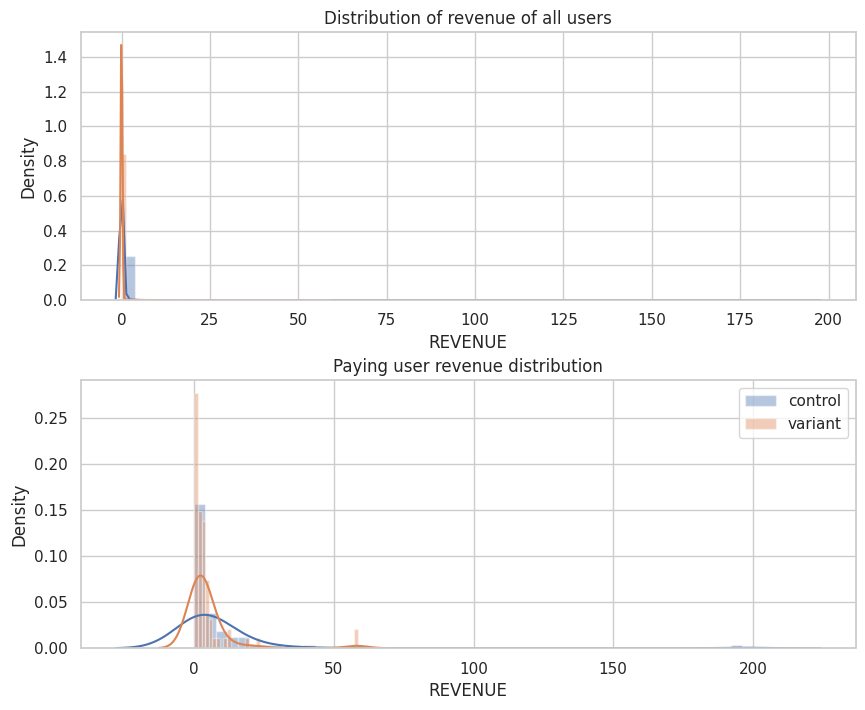

In [85]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [86]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

control_all_users = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']
variant_all_users = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE']

stat_control_all, p_value_control_all = shapiro(control_all_users)
stat_variant_all, p_value_variant_all = shapiro(variant_all_users)

control_paying_users = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE']
variant_paying_users = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE']

stat_control_paying, p_value_control_paying = shapiro(control_paying_users)
stat_variant_paying, p_value_variant_paying = shapiro(variant_paying_users)

print(f"Shapiro-Wilk Test for Control (All Users): Stat={stat_control_all}, p-value={p_value_control_all}")
print(f"Shapiro-Wilk Test for Variant (All Users): Stat={stat_variant_all}, p-value={p_value_variant_all}")
print(f"Shapiro-Wilk Test for Control (Paying Users): Stat={stat_control_paying}, p-value={p_value_control_paying}")
print(f"Shapiro-Wilk Test for Variant (Paying Users): Stat={stat_variant_paying}, p-value={p_value_variant_paying}")


Shapiro-Wilk Test for Control (All Users): Stat=0.01833147442513483, p-value=2.4983285100057203e-95
Shapiro-Wilk Test for Variant (All Users): Stat=0.027033073451830147, p-value=2.7310104028899288e-95
Shapiro-Wilk Test for Control (Paying Users): Stat=0.28080554615611364, p-value=6.50334178109615e-18
Shapiro-Wilk Test for Variant (Paying Users): Stat=0.4170522102926101, p-value=2.114043206787204e-15


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


Is the null hypothesis about the normal distribution of the data rejected ?

Rejected

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [87]:
(df['REVENUE'] == 0).value_counts()

,count
REVENUE,
True,9848
False,152


In [88]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

control_all_users = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']
variant_all_users = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE']
stat, p_value = mannwhitneyu(control_all_users, variant_all_users)

print(f"Mann-Whitney U Test Statistics: {stat}")
print(f"P-value: {p_value}")

Mann-Whitney U Test Statistics: 12521564.0
P-value: 0.47825247965294926


In [89]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

paying_users_df = df.loc[df['REVENUE'] > 0]
control_paying_users = paying_users_df.loc[paying_users_df['VARIANT_NAME'] == 'control', 'REVENUE']
variant_paying_users = paying_users_df.loc[paying_users_df['VARIANT_NAME'] == 'variant', 'REVENUE']
stat, p_value = mannwhitneyu(control_paying_users, variant_paying_users)

print(f"Mann-Whitney U Test Statistics (Paying Users): {stat}")
print(f"P-value (Paying Users): {p_value}")

Mann-Whitney U Test Statistics (Paying Users): 3356.0
P-value (Paying Users): 0.07924299810603061


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [90]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users

In [ ]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
